In [2]:
import os
os.environ['TF_CP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import pickle

GPU setting. It isn't neccessary in CoLab.

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

[]


In [4]:
with open('/content/drive/MyDrive/009.1.mid.position.base.array.pkl', 'rb') as file:
    y_arr =pickle.load(file)
with open('/content/drive/MyDrive/009.2.5mer.feature.pkl', 'rb') as file:
    x_arr_3d = pickle.load(file)
print(y_arr.shape)
print(x_arr_3d.shape)

(214966, 5)
(214966, 5, 7)


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

n_shuffles = 5

for i in range(n_shuffles):
    x_arr_3d, y_arr = shuffle(x_arr_3d, y_arr, random_state= i )


X_train, X_test, y_train, y_test = train_test_split(x_arr_3d, y_arr, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(171972, 5, 7)
(171972, 5)
(42994, 5, 7)
(42994, 5)


In [6]:
from sklearn.utils import class_weight

y_train_labels= np.where(y_train==1)[1]
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train_labels),
                                                  y=y_train_labels)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: 0.7739339798834409, 1: 1.5018077023840712, 2: 0.7913853799958583, 3: 1.0463766352296928, 4: 1.215435719838858}


In [7]:
model = keras.Sequential([
    # tf.keras.Input()-- instantiate a Keras tensor
    # In TensorFlow Keras, input layers are essential for defining the expected
    # shape and data type of input data for a neural network. There are two primary
    #  ways to define input layers: keras.Input and keras.layers.InputLayer.
    # --keras.Input: This approach is often favored for its conciseness and flexibility,
    #  especially when building models using the Functional API. It directly creates a
    # symbolic tensor-like object representing the input.
    # Define an input layer for a sequence of 5 time steps with 7 features each
    # None for batch size
    keras.Input(shape = (5,7), dtype = "float32"),
    layers.Bidirectional(layers.GRU(units=128, return_sequences=True)),
    layers.Bidirectional(layers.GRU(units=128, return_sequences=True)),
    layers.Bidirectional(layers.GRU(units=128)),
    layers.Dense(units = 5, activation='softmax')
])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 5, 256)              │         105,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 5, 256)              │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 256)                 │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 699,397 (2.67 MB)

 Trainable params: 699,397 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
              # If you want to provide labels using one-hot representation, please use CategoricalCrossentropy loss
              # from_logits in keras.losses.CategoricalCrossentropy should be set to True when the
              # output of your model's last layer has not passed through a softmax
              # activation function.
              loss=tf.keras.losses.CategoricalCrossentropy(
                    from_logits=False,
                    label_smoothing=0.0,
                    axis=-1,
                    reduction='sum_over_batch_size',
                    name='categorical_crossentropy'
                  ),
              loss_weights = None,
              metrics=['categorical_accuracy', 'precision', 'recall',
                       keras.metrics.AUC(name='prc', curve='PR')])

In [9]:
model.fit(X_train, y_train,
          batch_size = 128,
          # An epoch, in Machine Learning, is the entire processing
          # by the learning algorithm of the entire train-set.
          epochs = 10,
          class_weight = class_weights_dict,
          verbose = 2)

Epoch 1/10
1344/1344 - 175s - 130ms/step - categorical_accuracy: 0.8666 - loss: 0.3539 - prc: 0.9568 - precision: 0.8955 - recall: 0.8463
Epoch 2/10
1344/1344 - 199s - 148ms/step - categorical_accuracy: 0.9310 - loss: 0.2154 - prc: 0.9827 - precision: 0.9320 - recall: 0.9302
Epoch 3/10
1344/1344 - 201s - 150ms/step - categorical_accuracy: 0.9392 - loss: 0.1941 - prc: 0.9856 - precision: 0.9402 - recall: 0.9382
Epoch 4/10
1344/1344 - 160s - 119ms/step - categorical_accuracy: 0.9438 - loss: 0.1809 - prc: 0.9873 - precision: 0.9448 - recall: 0.9429
Epoch 5/10
1344/1344 - 159s - 118ms/step - categorical_accuracy: 0.9469 - loss: 0.1708 - prc: 0.9886 - precision: 0.9479 - recall: 0.9459
Epoch 6/10
1344/1344 - 203s - 151ms/step - categorical_accuracy: 0.9503 - loss: 0.1616 - prc: 0.9897 - precision: 0.9513 - recall: 0.9493
Epoch 7/10
1344/1344 - 197s - 147ms/step - categorical_accuracy: 0.9526 - loss: 0.1525 - prc: 0.9908 - precision: 0.9536 - recall: 0.9518
Epoch 8/10
1344/1344 - 205s - 153m

In [10]:
model.evaluate(X_test, y_test,
               batch_size = 128,
               verbose = 2)
#model.metrics_names

336/336 - 13s - 39ms/step - categorical_accuracy: 0.9481 - loss: 0.1511 - prc: 0.9858 - precision: 0.9490 - recall: 0.9476


[0.15112483501434326,
 0.9481322765350342,
 0.9489879012107849,
 0.947597324848175,
 0.985807478427887]

In [11]:
print("model.input_shape:", model.input_shape)

model.input_shape: (None, 5, 7)


In [12]:
## confusion matrix
labels= np.where(y_test==1)[1]
print(labels)
def softmax_to_label(softmax_output):
  """Converts softmax probabilities to a label encoded value.

  Args:
    softmax_output: A list or numpy array of probabilities.

  Returns:
    The index of the highest probability.
  """
  return np.argmax(softmax_output)
predictions = model.predict(X_test)


[0 2 4 ... 2 3 2]
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step


In [13]:
predictions_label = np.apply_along_axis(softmax_to_label,  1, predictions)
print(len(predictions_label))
confusion_matrix = tf.math.confusion_matrix(labels,
                                           predictions_label,
                                           num_classes=5)

# Print the confusion matrix
print(confusion_matrix.numpy())

42994
[[11203    14    15    20     8]
 [   14  4702    17    10   874]
 [   17    21 10918    11    15]
 [   15    10     9  8128    15]
 [   11  1109    11    14  5813]]


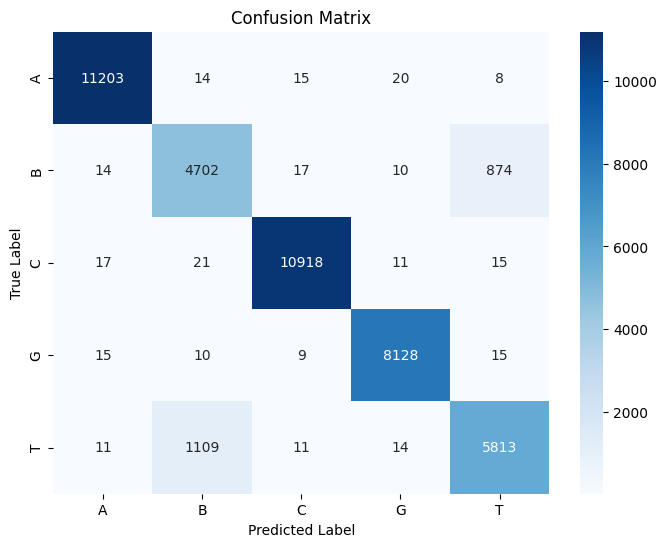

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class_names = ["A","B", "C", "G", "T"]
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


plot_confusion_matrix(confusion_matrix.numpy(), class_names)
# Evaluate the confusion matrix within a TensorFlow session or eager context
# with tf.compat.v1.Session() as sess:
#     np_cm = sess.run(confusion_matrix)
#     plot_confusion_matrix(np_cm, class_names)